Laboratorio 3
integrantes:

- Francis Aguilar - 22243
- César López - 22535
- Angela García -22869
 
enlace al repositorio: https://www.kaggle.com/code/angelargd8/lab3-ds

In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image

2025-08-01 19:32:17.984462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754076738.254516      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754076738.333260      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Análisis exploratorio

In [3]:
print("Contenido de /kaggle/input:")
print(os.listdir("/kaggle/input"))

Contenido de /kaggle/input:
['mnist-multiple-dataset-comprehensive-analysis']


In [4]:
base_root = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis"

print("Contenido dentro del dataset:")
print(os.listdir(base_root))

Contenido dentro del dataset:
['label.json', 'model.pth', 'README.md', 'PolyMNIST', 'label.csv', 'MNIST-MIX-all']


In [5]:
poly_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST"
print("Contenido en PolyMNIST:", os.listdir(poly_path))

Contenido en PolyMNIST: ['MMNIST']


In [6]:
mmnist_path = os.path.join(poly_path, "MMNIST")
print("Contenido en MMNIST:", os.listdir(mmnist_path))

Contenido en MMNIST: ['test', 'train']


In [7]:
train_path = os.path.join(mmnist_path, "train")
print("Contenido en train:", os.listdir(train_path))

Contenido en train: ['m4', 'm2', 'm0', 'm1', 'm3']


El conjunto de datos de polyMNIST tiene cinco modalidades distintas. El fondo de cada modalidad se compone de parches aleatorios recortados de una imagen más grande, con el dígito colocado aleatoriamente dentro de estos parches. Esta configuración proporciona a cada modalidad información única de su imagen de fondo, mientras que el dígito sirve como información compartida entre todas las modalidades. Un desafío adicional, en comparación con el PolyMNIST original, es la traducción aleatoria de los dígitos.

Descripción tomada de: https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/data

En el conjunto de datos, algo importante de ver antes de colocar los datos en un dataframe, es que el nombre de los archivos tiene el siguiente formato:

**id.etiqueta.png**


In [8]:
#leer las imagenes del dataset y extraer sus etiquetas 
base_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train"

data = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".png"):
            full_path = os.path.join(root, file)
            label = file.split('.')[1]
            data.append((full_path, int(label)))

df = pd.DataFrame(data, columns=["filepath", "label"])
print(df.head(), "\nTotal imágenes:", len(df))


                                            filepath  label
0  /kaggle/input/mnist-multiple-dataset-comprehen...      9
1  /kaggle/input/mnist-multiple-dataset-comprehen...      0
2  /kaggle/input/mnist-multiple-dataset-comprehen...      0
3  /kaggle/input/mnist-multiple-dataset-comprehen...      9
4  /kaggle/input/mnist-multiple-dataset-comprehen...      9 
Total imágenes: 300000


In [9]:
print("Primeras filas del DataFrame:")
print(df.head())


Primeras filas del DataFrame:
                                            filepath  label
0  /kaggle/input/mnist-multiple-dataset-comprehen...      9
1  /kaggle/input/mnist-multiple-dataset-comprehen...      0
2  /kaggle/input/mnist-multiple-dataset-comprehen...      0
3  /kaggle/input/mnist-multiple-dataset-comprehen...      9
4  /kaggle/input/mnist-multiple-dataset-comprehen...      9


In [10]:
# Ver tamaño del dataset
print("\nNúmero total de imágenes:", len(df))



Número total de imágenes: 300000


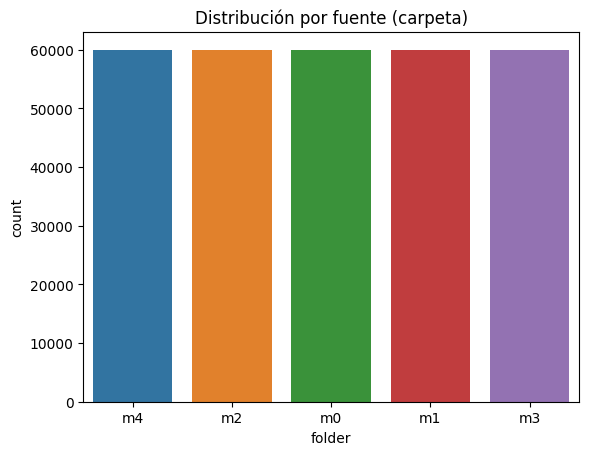

In [11]:
#imagenes por cada carpeta
df['folder'] = df['filepath'].apply(lambda x: x.split('/')[-2])
sns.countplot(data=df, x="folder")
plt.title("Distribución por fuente (carpeta)")
plt.show()

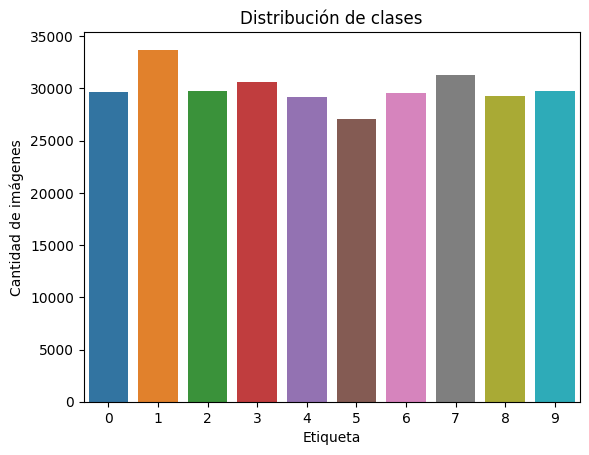

In [12]:
sns.countplot(data=df, x="label")
plt.title("Distribución de clases")
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad de imágenes")
plt.show()

La distribución de clases no parece tener un gran desbalance, sin embargo es ideal que este balanceada. En este caso se usara unsersampling, ya que son muchos datos y no tienen una gran diferencia en cuanto datos.

In [13]:
#balancear las clases, esta vez undersampling porque muy grande el dataset
from sklearn.utils import resample

min_count = df['label'].value_counts().min()
df = pd.concat([
    resample(df[df['label'] == label], replace=False, n_samples=min_count, random_state=42)
    for label in df['label'].unique()
])

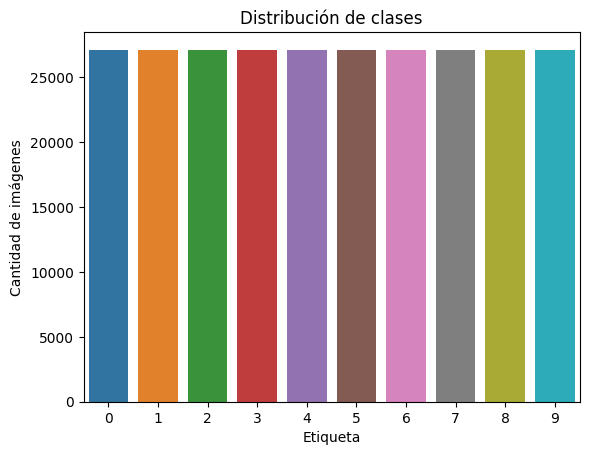

In [14]:
sns.countplot(data=df, x="label")
plt.title("Distribución de clases")
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad de imágenes")
plt.show()

In [15]:
# Duplicados por nombre
print("Duplicados:", df.duplicated("filepath").sum())

Duplicados: 0


In [16]:
# Tamaños de imagen
df['size'] = df['filepath'].apply(lambda path: Image.open(path).size)
print("Tamaños únicos:", df['size'].value_counts())

Tamaños únicos: size
(28, 28)    271050
Name: count, dtype: int64


La resolución es de: (28,28) píxeles

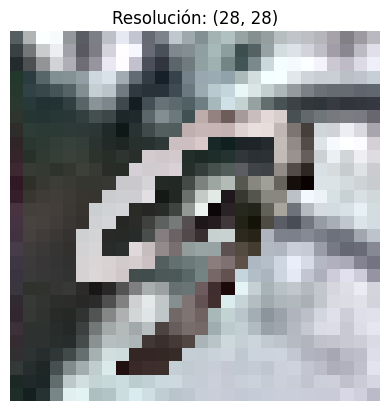

In [17]:
from PIL import Image
img = Image.open(df['filepath'].iloc[0])
plt.imshow(img, cmap='gray')
plt.title(f"Resolución: {img.size}")
plt.axis('off')
plt.show()

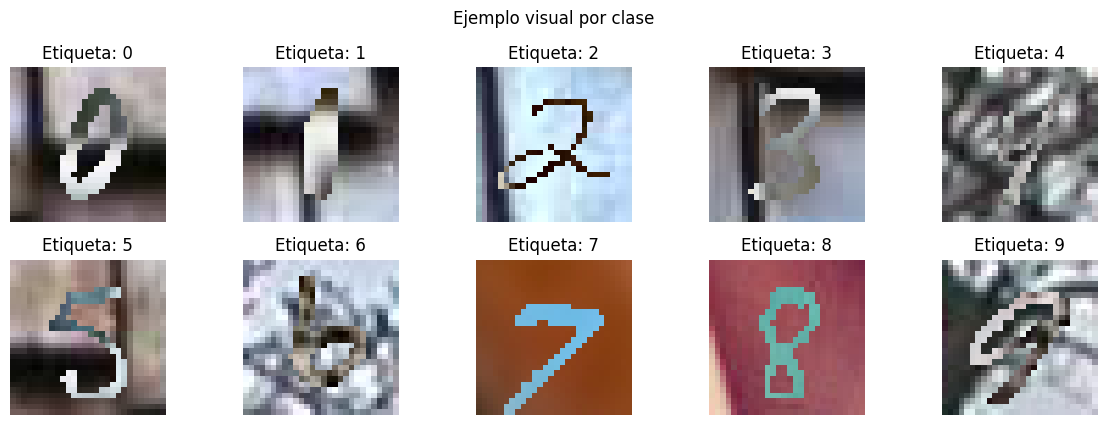

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

# Asegura que la columna 'label' es int
df['label'] = df['label'].astype(int)

# Obtener clases únicas
unique_labels = sorted(df['label'].unique())

# Mostrar una imagen por clase (máximo 10 si quieres limitar)
plt.figure(figsize=(12, 4))

for i, label in enumerate(unique_labels[:10]):
    subset = df[df['label'] == label]
    if not subset.empty:
        img_path = subset.iloc[0]['filepath']
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Etiqueta: {label}")
        plt.axis('off')

plt.tight_layout()
plt.suptitle("Ejemplo visual por clase", y=1.05)
plt.show()

En los ejemplos, se logra observar que dataset tiene una alta variabilidad visual y estilo porque cada uno tiene colores, fondos, tipografía, estilo de escritura y ruido. Y hay ciertos números que puede que por su fondo que tienen mucho ruido pueda causar problemas con el entrenamiento.

## Preparacion de datos

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

# Ruta base
#base_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST"

# Altura, ancho e input shape
img_height, img_width = 28, 28
input_shape = (img_height, img_width, 1)  # grayscale
batch_size = 64


In [20]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split


def cargar_datos(dataframe, img_height=28, img_width=28):
    X, y = [], []

    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Cargando imágenes"):
        path = row['filepath']
        label = row['label']

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_width, img_height))  # Asegura tamaño uniforme
        img = img.astype('float32') / 255.0  # normalizar

        X.append(img)
        y.append(label)

    X = np.expand_dims(np.array(X), -1)  # formato (N, 28, 28, 1)
    y = np.array(y)
    return X, y


train_df, test_df = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)
X_train, y_train = cargar_datos(train_df)
X_test, y_test = cargar_datos(test_df)

altura, ancho, canales = 28, 28, 1
num_clases = len(np.unique(y_train))
print("Clases: ", num_clases)


Cargando imágenes: 100%|██████████| 54210/54210 [02:07<00:00, 423.61it/s]


Clases:  10


In [21]:
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (216840, 28, 28, 1) (216840,)
Test: (54210, 28, 28, 1) (54210,)


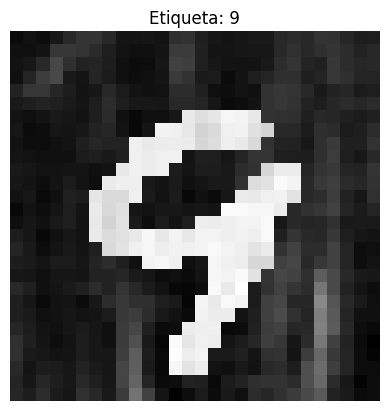

In [22]:
#verificar visualmente con una muestra
plt.imshow(X_train[0].squeeze(), cmap='gray')
plt.title(f"Etiqueta: {y_train[0]}")
plt.axis('off')
plt.show()

#### Funcion para evaluar modelos

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import numpy as np

def evaluar_modelo(modelo, X_test, y_test, nombre="Modelo"):
    print(f"\n=== Evaluación de {nombre} ===")
    loss, acc = modelo.evaluate(X_test, y_test, verbose=0)
    print(f"Accuracy: {acc:.4f} - Loss: {loss:.4f}\n")

    y_pred = modelo.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(classification_report(y_test, y_pred_classes, zero_division=0))

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta verdadera')
    plt.show()


#### Modelo CNN - 1

In [24]:
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(altura, ancho, canales)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_clases, activation='softmax')
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-01 20:20:53.198174: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 125s 18ms/step - accuracy: 0.8368 - loss: 0.5268 - val_accuracy: 0.9500 - val_loss: 0.1573
Epoch 2/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 121s 18ms/step - accuracy: 0.9563 - loss: 0.1381 - val_accuracy: 0.9623 - val_loss: 0.1206
Epoch 3/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 120s 18ms/step - accuracy: 0.9681 - loss: 0.0971 - val_accuracy: 0.9663 - val_loss: 0.1066
Epoch 4/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 120s 18ms/step - accuracy: 0.9751 - loss: 0.0759 - val_accuracy: 0.9631 - val_loss: 0.1210
Epoch 5/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 121s 18ms/step - accuracy: 0.9785 - loss: 0.0642 - val_accuracy: 0.9691 - val_loss: 0.1055
Epoch 6/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 132s 19ms/step - accuracy: 0.9817 - loss: 0.0538 - val_accuracy: 0.9655 - val_loss: 0.1137
Epoch 7/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 130s 19ms/step - accuracy: 0.9836 - loss: 0.0477 - val_accuracy: 0.9709 - val_loss: 0.1145
Epoch 8/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 129s 19ms/step - accuracy: 


=== Evaluación de CNN 1 ===
Accuracy: 0.9675 - Loss: 0.1378

1695/1695 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5421
           1       0.98      0.98      0.98      5421
           2       0.97      0.97      0.97      5421
           3       0.96      0.97      0.96      5421
           4       0.93      0.99      0.96      5421
           5       0.98      0.96      0.97      5421
           6       0.98      0.98      0.98      5421
           7       0.97      0.97      0.97      5421
           8       0.95      0.97      0.96      5421
           9       0.98      0.92      0.95      5421

    accuracy                           0.97     54210
   macro avg       0.97      0.97      0.97     54210
weighted avg       0.97      0.97      0.97     54210



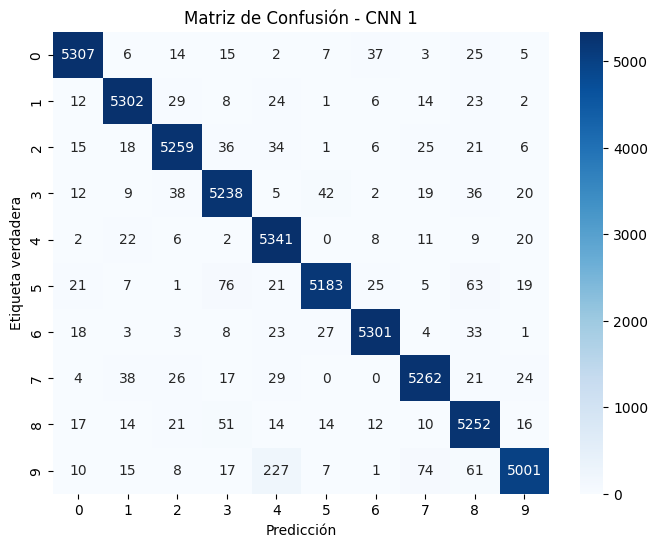

In [25]:
evaluar_modelo(model1, X_test, y_test, "CNN 1")

Los resultados del primer modelo son bastante sorprendentes, ya que tiene un accuracy de 0.9732 y una perdida de 0.1024, lo que nos indica que la mayoría de los dígitos se clasifican correctamente y las áreas de mejora son las clases del número 8 y 9, porque allí es dónde más se ha confundido el modelo al clasificar, pero eso puede ser por el ruido en los fondos. 

#### Modelo CNN - 2

In [26]:
model2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(altura, ancho, canales)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_clases, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 206s 30ms/step - accuracy: 0.8370 - loss: 0.5121 - val_accuracy: 0.9350 - val_loss: 0.2062
Epoch 2/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 201s 30ms/step - accuracy: 0.9440 - loss: 0.1829 - val_accuracy: 0.9128 - val_loss: 0.2719
Epoch 3/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 201s 30ms/step - accuracy: 0.9534 - loss: 0.1541 - val_accuracy: 0.9530 - val_loss: 0.1569
Epoch 4/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 199s 29ms/step - accuracy: 0.9593 - loss: 0.1347 - val_accuracy: 0.9630 - val_loss: 0.1294
Epoch 5/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 200s 30ms/step - accuracy: 0.9628 - loss: 0.1220 - val_accuracy: 0.9659 - val_loss: 0.1082
Epoch 6/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 200s 30ms/step - accuracy: 0.9649 - loss: 0.1136 - val_accuracy: 0.9479 - val_loss: 0.1601
Epoch 7/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 199s 29ms/step - accuracy: 0.9672 - loss: 0.1059 - val_accuracy: 0.9716 - val_loss: 0.0911
Epoch 8/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 201s 30ms/step - accuracy: 


=== Evaluación de CNN 2 ===
Accuracy: 0.9764 - Loss: 0.0772

1695/1695 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5421
           1       0.99      0.98      0.99      5421
           2       0.99      0.97      0.98      5421
           3       0.97      0.98      0.98      5421
           4       0.96      0.98      0.97      5421
           5       0.99      0.96      0.97      5421
           6       0.97      0.99      0.98      5421
           7       0.98      0.97      0.98      5421
           8       0.97      0.97      0.97      5421
           9       0.97      0.96      0.96      5421

    accuracy                           0.98     54210
   macro avg       0.98      0.98      0.98     54210
weighted avg       0.98      0.98      0.98     54210



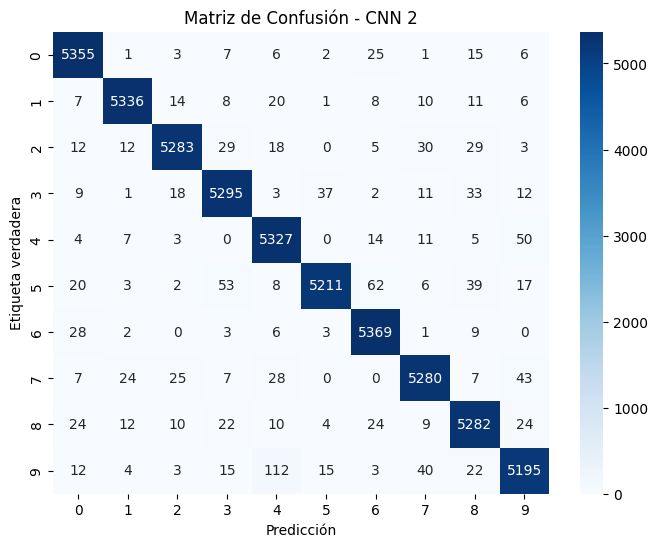

In [27]:
evaluar_modelo(model2, X_test, y_test, "CNN 2")

Los resultados del modelo 2, muestran un buen rendimiento teniendo un accuracy de 0.9714 con una perdida de 0.0929. La clase 2 tiene casi un 100% de recall, pero tiene una precisión baja porque hay varias predicciones falsas como 1 desde la clase 8, entonces allí parece que el modelo sobregeneraliza como clase 1. Mientras, en la clase 8 y 9 sigue con varios errores comunes. La clase 9 se ocnfunde mucho con el 4, 6 y 8.

#### Conclusion:
Luego de entrenar y comparar ambos modelos, notamos que los dos tienen un rendimiento bastante bueno al reconocer los dígitos. Sin embargo, el primer modelo fue un poco más preciso, presentó una matriz de confusión más concentrada, lo que indica una mejor capacidad de generalización frente a nuevas instancias. A pesar de eso, el segundo modelo es bastente robusto y es más regularizado aunque sí tiene una leve pérdida de precisión en algunas clases y tiene un poco más de dispersión en las clases 8 y 9.  Se considera que aunque los dos modelos sean un poco parecidos en cuanto resultados, el primer modelo es preferible si la prioridad es la precisión y el segundo modelo cuando se busca una mejor regularización y estabilidad a variaciones de datos. Por lo cual, el modelo que consideramos mejor es el segundo, ya que responde mejor a datos nuevos.


#### Modelo Red Neuronal Simple

In [28]:
model_simple = models.Sequential([
    layers.Flatten(input_shape=(altura, ancho, canales)),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_clases, activation='softmax')
])

model_simple.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_simple.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.4366 - loss: 1.6271 - val_accuracy: 0.6504 - val_loss: 1.0658
Epoch 2/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6930 - loss: 0.9760 - val_accuracy: 0.7251 - val_loss: 0.8850
Epoch 3/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.7355 - loss: 0.8421 - val_accuracy: 0.7569 - val_loss: 0.8013
Epoch 4/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7581 - loss: 0.7765 - val_accuracy: 0.7788 - val_loss: 0.7562
Epoch 5/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.7742 - loss: 0.7282 - val_accuracy: 0.7797 - val_loss: 0.7275
Epoch 6/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7821 - loss: 0.7015 - val_accuracy: 0.7695 - val_loss: 0.7495
Epoch 7/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7911 - loss: 0.6738 - val_accuracy: 0.7791 - val_loss: 0.7232
Epoch 8/10
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7967 - loss: 0


=== Evaluación de Modelo Red neuronal simple ===
Accuracy: 0.8019 - Loss: 0.6695

1695/1695 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      5421
           1       0.87      0.88      0.87      5421
           2       0.67      0.82      0.74      5421
           3       0.73      0.82      0.77      5421
           4       0.87      0.76      0.81      5421
           5       0.80      0.79      0.79      5421
           6       0.78      0.90      0.84      5421
           7       0.79      0.83      0.81      5421
           8       0.83      0.72      0.77      5421
           9       0.87      0.67      0.76      5421

    accuracy                           0.80     54210
   macro avg       0.81      0.80      0.80     54210
weighted avg       0.81      0.80      0.80     54210



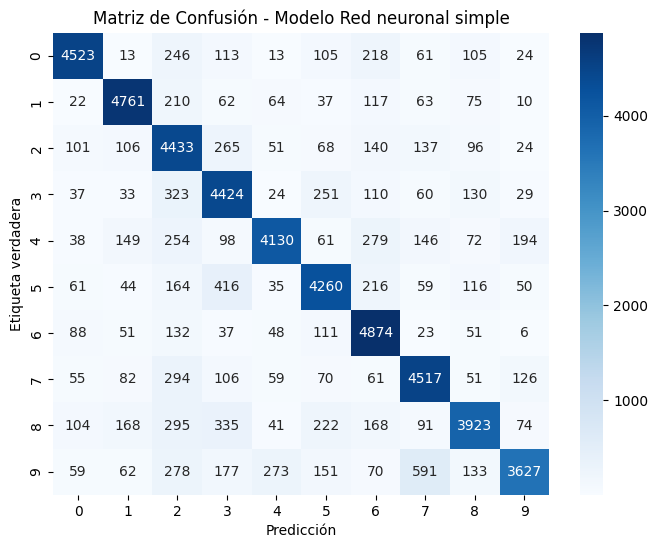

In [29]:
evaluar_modelo(model_simple, X_test, y_test, "Modelo Red neuronal simple")

Los resultados del Modelo de Red Neuronal simple, son notoriamente menor que los de CNN, teniendo un accuracy de 0.7954 y una perdida de 0.6752. En la clase 5, 8 y 9 se ve que el modelo tuvo varias complicaciones para poder clasificar correctamente. Este modelo con clases como 0, 1 y 6 tienen un recall bastante alto y allí muestra que tiene patrones más consistentes. Lo que puede estar pasando es que el modelo no capta bien las caracteristicas locales, como las curvas o bordes ya que no usa convoluciones y este solo aplana las imagénes. 

## modelo de Linear Classifier (1-layer NN)

In [30]:
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model

model_linear = models.Sequential([
    layers.Flatten(input_shape=input_shape),          
    layers.Dense(num_clases, activation='softmax') # Una capa lineal
])

model_linear.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#entrenar
history_linear = model_linear.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_test, y_test),
    verbose=2
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1695/1695 - 6s - 4ms/step - accuracy: 0.3699 - loss: 2.1429 - val_accuracy: 0.3882 - val_loss: 2.1291
Epoch 2/10
1695/1695 - 5s - 3ms/step - accuracy: 0.4084 - loss: 2.1118 - val_accuracy: 0.4225 - val_loss: 2.0974
Epoch 3/10
1695/1695 - 5s - 3ms/step - accuracy: 0.4135 - loss: 2.1067 - val_accuracy: 0.4274 - val_loss: 2.0974
Epoch 4/10
1695/1695 - 5s - 3ms/step - accuracy: 0.4141 - loss: 2.1045 - val_accuracy: 0.4264 - val_loss: 2.0940
Epoch 5/10
1695/1695 - 5s - 3ms/step - accuracy: 0.4149 - loss: 2.1042 - val_accuracy: 0.3968 - val_loss: 2.1178
Epoch 6/10
1695/1695 - 5s - 3ms/step - accuracy: 0.4148 - loss: 2.1036 - val_accuracy: 0.4092 - val_loss: 2.1015
Epoch 7/10
1695/1695 - 5s - 3ms/step - accuracy: 0.4153 - loss: 2.1015 - val_accuracy: 0.4012 - val_loss: 2.1120
Epoch 8/10
1695/1695 - 5s - 3ms/step - accuracy: 0.4153 - loss: 2.1022 - val_accuracy: 0.3979 - val_loss: 2.1161
Epoch 9/10
1695/1695 - 5s - 3ms/step - accuracy: 0.4175 - loss: 2.0988 - val_accuracy: 0.4252 - 


=== Evaluación de Modelo Linear Classifier de 1 capa ===
Accuracy: 0.4185 - Loss: 2.1052

1695/1695 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

           0       0.67      0.46      0.54      5421
           1       0.26      0.55      0.36      5421
           2       0.22      0.49      0.31      5421
           3       0.55      0.38      0.45      5421
           4       0.85      0.31      0.45      5421
           5       0.32      0.43      0.37      5421
           6       0.61      0.45      0.52      5421
           7       0.53      0.44      0.48      5421
           8       0.67      0.34      0.45      5421
           9       0.64      0.33      0.44      5421

    accuracy                           0.42     54210
   macro avg       0.53      0.42      0.44     54210
weighted avg       0.53      0.42      0.44     54210



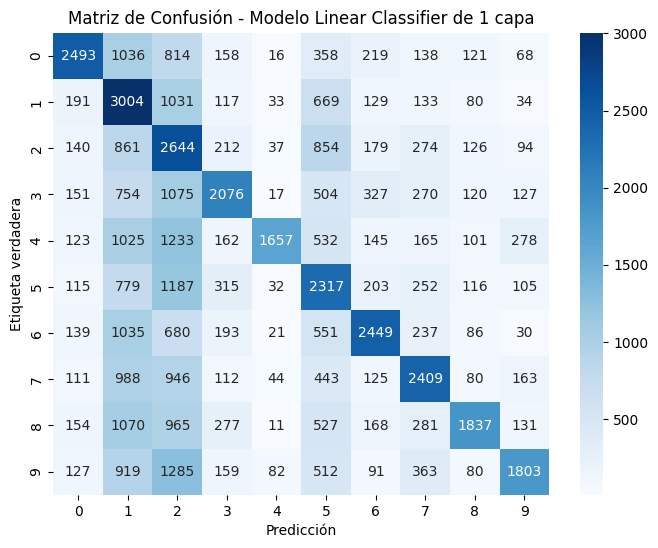

In [31]:
evaluar_modelo(model_linear, X_test, y_test, "Modelo Linear Classifier de 1 capa")

Los resultados del modelo Linear Classifier con 1 capa tiene un accuracy bastante bajo que es de 0.4308 y una perdida de 2.0917. Lo que nos indica que el modelo no tiene la capacidad de aprender relaciones no lineales ni la estructura espacial de los números. Este modelo tiene una gran confusión de clases, esto se nota bastante en los números que tienen formas similares cómo el 4, 1 y 6 con el  9 o el 5 con el  3. Y la clase 2 fue confundida con 1, 3 y 7. Lo que se puede ver en la matriz es que tiene mucha dispersión. EL modelo no parece ser indicado para clasificar imágenes por sí solo. A pesar de todo esto, fue el modelo que tuvo un entrenamiento más rápido por su simplicidad. 